# Introduction

# Introduction

In this  twenty first century the internet has become an important part of human life, however there is the downside and upside of the situation. The downside is that users are presented with numerous choices of products such as real estate, investment  options and movie products, among others. To help  users cope with this information explosion, companies have deployed recommendation systems to guide their users. The interest in development of recommendation systems remains high because of the abundance of practical applications and the problem rich domain. Several such online recommendation systems implemented and used  include movie  Recommender Systems. Movie Recommender Systems have significantly contributed to the economy of  organisations such as Netflix which have made these systems a salient part of their websites. For example, Netflix, 2/3rd of the movies watched are recommended .To this end JS3 team saw the need to develop  a  movie recommender system. That can be deployed by movie houses to enhance their profitability.


# Problem statement


Due to information explosion , the need to build relationships between products and users to  enhance the probability of a specific user selecting the most appropriate product is escalating. As a result recommender systems are increasingly sought after for this objective to be realised. 

# Import libraries and datasets

First we need to load the libraries we are going to use throughout our notebook

In [1]:
# do basic imports
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp
# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#wod cloud
from PIL import Image
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('dark')
%matplotlib inline

# Data Extraction

In [3]:
# load data
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
imdb_data = pd.read_csv('imdb_data.csv')
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Exploratory Data Analysis

#### View the dataframes loaded

## Genome scores and tags

In [5]:
genome_scores.head(2)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375


In [6]:
# check length 
len(genome_scores)

15584448

In [7]:
genome_tags.head(2)

,tagId,tag
0,1,007
1,2,007 (series)


In [8]:
len(genome_tags)

1128

# IMDB data

In [9]:
imdb_data.head(2)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game


In [10]:
len(imdb_data['movieId'])

27278

## Links and Movies

In [11]:
links.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [12]:
len(links['movieId'])

62423

In [14]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [15]:
len(movies['movieId'])

62423

## Tags

In [16]:
tags.head(2)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256


In [17]:
len(tags['movieId'])

1093360

# Train and test

In [19]:
train.head(2)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739


In [20]:
len(train)

10000038

#Checking any empty values 

In [22]:
i=0
for x in train.columns:
    if '' in sorted(train[x].unique()):
        i+=1
print('The data contains '+str(i)+' empty values over all columns')

The data contains 0 empty values over all columns


The data contains 0 empty values over all columns
None of our columns contain any null or empty values.



Checking for duplicate values in the dataset using the .duplicated which returns a boolean Series denoting duplicate rows

In [23]:
# Store dDuplications
val_bool = train.duplicated(['userId', 'movieId', 'rating'])

# Show Duplications
print("Number of duplicated values:", sum(val_bool))

Number of duplicated values: 0


Our data has no duplicates

In [24]:
test.head(2)

,userId,movieId
0,1,2011
1,1,4144


In [25]:
len(test)

5000019

## Merge train with movies

In [29]:
train_movies = pd.merge(train, movies, on='movieId')
train_movies.head(2)

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller


### EDA on train_movies

In [30]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])


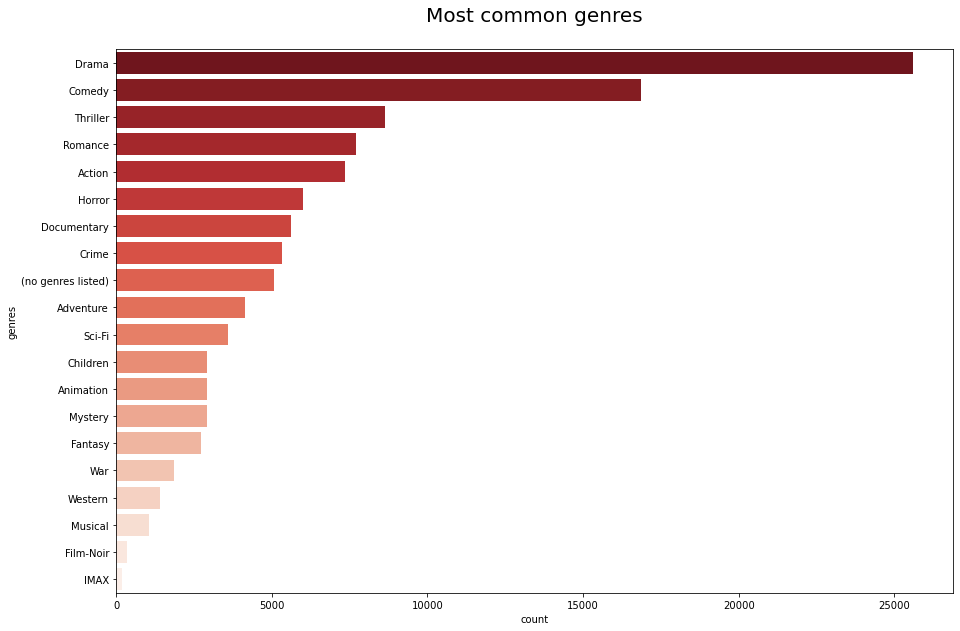

In [31]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()


Drama is the leading genre in our dataset.Drama is often serious stories based on incidents that occur on a regular basis in ordinary life. These films depict genuine persons who are at odds with themselves, others, or natural forces. They mainly concentrate on the characters and how they develop through time. Because most movies shows rely on character-driven storytelling to keep audiences engaged, drama is frequently mixed with other genres.Comedy continues to be one of the most popular film genres. It is a popular film genre among both youngsters and adults since these films have the ability to make an entire audience laugh and smile.


In [32]:
# check the length of train_movies
len(train_movies)

10000038

In [25]:
# check for null values
train_movies.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

there is no null values to we can go further

In [34]:
# display last 5 rows of train_movies
train_movies.tail(3)

,userId,movieId,rating,timestamp,title,genres
10000035,131116,206347,3.0,1568558126,Nocturne (1946),Crime|Drama|Mystery
10000036,85757,196867,3.5,1563175258,Guys & Balls (2004),Comedy|Romance
10000037,72315,97148,3.0,1567584197,Elia Kazan: A Director's Journey (1995),Documentary


In [35]:
# top 20 movies based on their ratings
train_movies.groupby('title')['rating'].mean().sort_values(ascending=False).head(20)

title
Which Way Home (2009)                                       5.0
Kaakha Kaakha (2003)                                        5.0
Not Quite Human II (1989)                                   5.0
Selling Isobel (2018)                                       5.0
Sehar (2005)                                                5.0
The Enchanted Sedan Chair (1905)                            5.0
K.G.F: Chapter 1 (2018)                                     5.0
Hard Cash (2002)                                            5.0
Everyone's Going to Die (2013)                              5.0
Anything for Love (2016)                                    5.0
Chain of Command (2015)                                     5.0
A Killing in a Small Town (1990)                            5.0
Political Animals (2016)                                    5.0
Kabir Singh (2019)                                          5.0
Everything Is Terrible! Presents: The Great Satan (2017)    5.0
Yamadonga (2007)                  

In [36]:
# Top 20 movies that were rated the most
train_movies.groupby('title')['rating'].count().sort_values(ascending=False).head(20)

title
Shawshank Redemption, The (1994)                                                  32831
Forrest Gump (1994)                                                               32383
Pulp Fiction (1994)                                                               31697
Silence of the Lambs, The (1991)                                                  29444
Matrix, The (1999)                                                                29014
Star Wars: Episode IV - A New Hope (1977)                                         27560
Jurassic Park (1993)                                                              25518
Schindler's List (1993)                                                           24004
Braveheart (1995)                                                                 23722
Fight Club (1999)                                                                 23536
Terminator 2: Judgment Day (1991)                                                 23075
Toy Story (1995)          

In [37]:
#create a dataframe for analysis
num_of_ratings = pd.DataFrame(train_movies.groupby('title')['rating'].mean().sort_values(ascending=False))
num_of_ratings['total number of ratings'] = pd.DataFrame(train_movies.groupby('title')['rating'].count()) 

In [38]:
num_of_ratings.head(2)

,rating,total number of ratings
title,,
Which Way Home (2009),5.0,1
Kaakha Kaakha (2003),5.0,1


Let's create a new dataframe also containing the `title`, `rating` and `total number of ratings`, but this time we will sort by the `total number of ratings`.

In [39]:
#create a dataframe for analysis
new_trend = pd.DataFrame(train_movies.groupby('title')['rating'].mean())
new_trend['total number of ratings'] = pd.DataFrame(train_movies.groupby('title')['rating'].count())

In [40]:
# sort dataframe by total number of ratings
new_trend.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
new_trend.reset_index(inplace=True)

In [41]:
new_trend.head(3)

,title,rating,total number of ratings
0,"Shawshank Redemption, The (1994)",4.417624,32831
1,Forrest Gump (1994),4.047216,32383
2,Pulp Fiction (1994),4.195097,31697


<AxesSubplot:xlabel='total number of ratings', ylabel='title'>

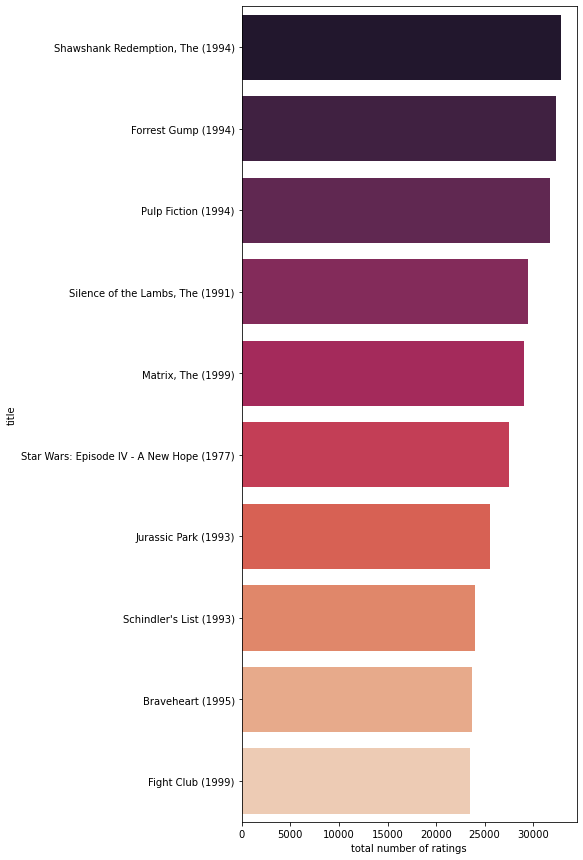

In [42]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.barplot(x="total number of ratings", y="title", data=new_trend.head(10), palette='rocket')

Text(0.5, 1.0, 'Distribution of Ratings')

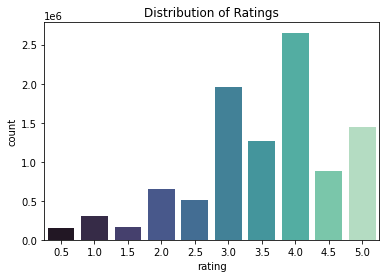

In [43]:
# plot distribution of ratings
sns.countplot(x = 'rating', data = train_movies, palette="mako")
plt.title("Distribution of Ratings")
#flare
#crest
#magma
#viridis
#rocket_r

The graph above shows distribution of ratings across each data set.

In [44]:
##DISTRIBUTION OF RATINGS


In [45]:
#create a dataframe for analysis
user_id = pd.DataFrame(train_movies.groupby('userId')['rating'].mean())
user_id['total number of ratings'] = pd.DataFrame(train_movies.groupby('userId')['rating'].count())

In [46]:
user_id.head(2)

,rating,total number of ratings
userId,,
1,3.910714,28
2,3.416667,72


In [47]:
# sort dataframe by total number of ratings
user_id.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
user_id.reset_index(inplace=True)

In [48]:
user_id.head(5)

,userId,rating,total number of ratings
0,72315,3.092380,12952
1,80974,3.277582,3680
2,137293,3.192168,3588
3,33844,2.583853,3208
4,20055,3.179016,3050


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '72315'),
  Text(1, 0, '80974'),
  Text(2, 0, '137293'),
  Text(3, 0, '33844'),
  Text(4, 0, '20055'),
  Text(5, 0, '109731'),
  Text(6, 0, '49403'),
  Text(7, 0, '92046'),
  Text(8, 0, '110971'),
  Text(9, 0, '30879')])

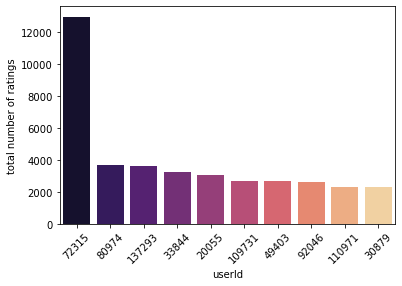

In [49]:
#total number of ratings per user id
sns.barplot(y="total number of ratings", x="userId", data=user_id.head(10), 
            order = user_id.head(10).sort_values('total number of ratings', ascending=False).userId, palette='magma')
plt.xticks(rotation=45)

A large number of users may be reviewing and rating specific movies. While the other movies may be rated by as few as one user. In such cases, some less popular films may be added to the recommendation list, while others may be excluded.

In [50]:
imdb_data.dropna(inplace=True)

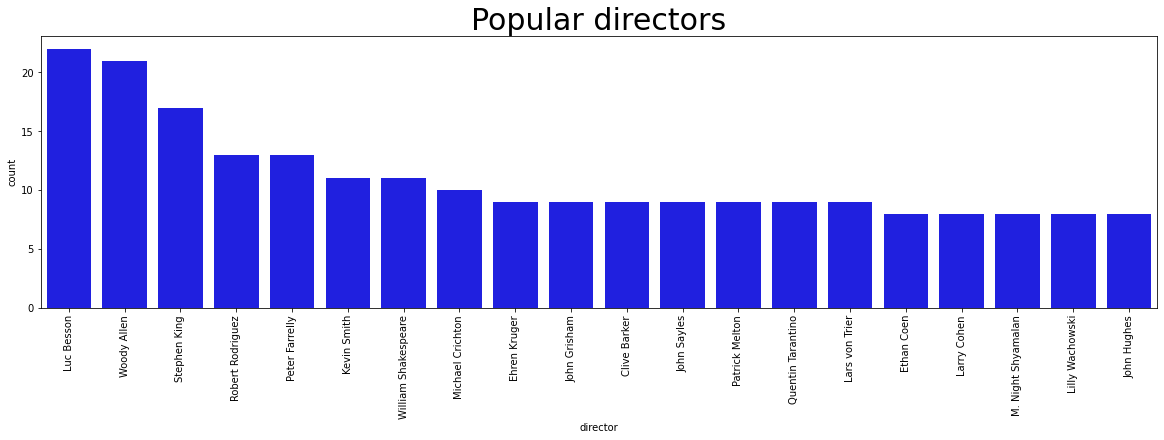

In [51]:
# Plot popular directors
plt.figure(figsize = (20,5))
directors=imdb_data['director'].explode()
ax=sns.countplot(x=directors, order = directors.value_counts().index[:20],color='blue')
ax.set_title('Popular directors',fontsize=30)
plt.xticks(rotation=90)
plt.show()

Viewers consider the director of the film, and if they have previously enjoyed a film directed by that filmmaker, they are more inclined to watch another film directed by that director.

In [54]:
#create a dataframe for analysis
ratings_trend = pd.DataFrame(train_movies.groupby('movieId')['rating'].mean())
ratings_trend['total number of ratings'] = pd.DataFrame(train_movies.groupby('movieId')['rating'].count()) 
ratings_trend.head(5)

,rating,total number of ratings
movieId,,
1,3.889971,23062
2,3.263414,9654
3,3.132325,4727
4,2.878099,968
5,3.059165,4648


In [55]:
#create a dataframe for analysis
new_trend = pd.DataFrame(train_movies.groupby('title')['rating'].mean())
new_trend['total number of ratings'] = pd.DataFrame(train_movies.groupby('title')['rating'].count())

In [56]:
# sort dataframe by total number of ratings
new_trend.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
new_trend.reset_index(inplace=True)

<AxesSubplot:xlabel='total number of ratings', ylabel='title'>

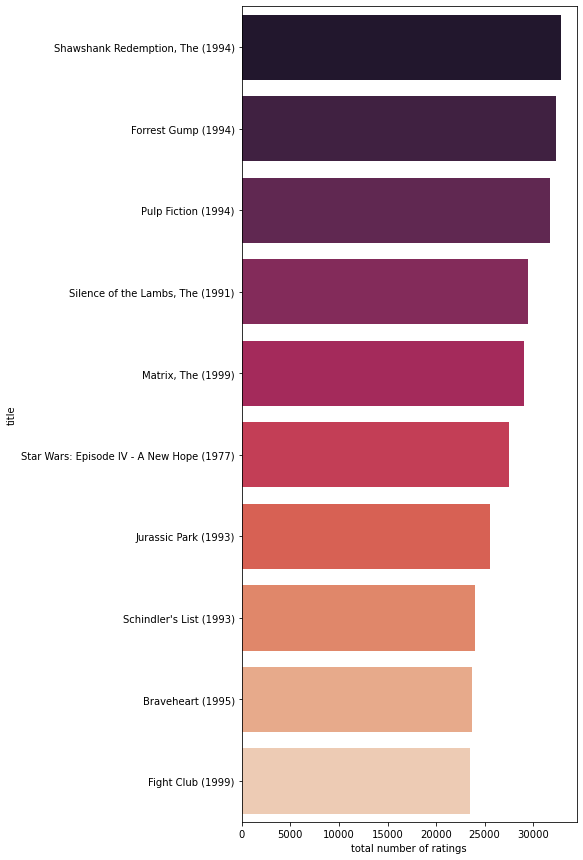

In [57]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.barplot(x="total number of ratings", y="title", data=new_trend.head(10), palette='rocket')

In [47]:
# Create dataframe containing only the movieId and keywords
imdb_keywords = pd.DataFrame(imdb_data[['movieId', 'plot_keywords']],
                             columns=['movieId', 'plot_keywords'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
imdb_keywords.plot_keywords = imdb_keywords.plot_keywords.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
imdb_keywords = pd.DataFrame([(tup.movieId,d) for tup in imdb_keywords.itertuples() for d in tup.plot_keywords],
                             columns=['movieId', 'plot_keywords'])

imdb_keywords.head()

,movieId,plot_keywords
0,1,toy
1,1,rivalry
2,1,cowboy
3,1,cgi animation
4,2,board game


In [48]:
# Create dataframe containing only the movieId and title_casts
imdb_casts = pd.DataFrame(imdb_data[['movieId', 'title_cast']],
                             columns=['movieId', 'title_cast'])

# Split title_casts seperated by "|" and create a list containing the title_cast allocated to each movie
imdb_casts.title_cast = imdb_casts.title_cast.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-title_cast combination is in a seperate row
imdb_casts = pd.DataFrame([(tup.movieId, d) for tup in imdb_casts.itertuples() for d in tup.title_cast],
                             columns=['movieId', 'title_cast'])

imdb_casts.head()

,movieId,title_cast
0,1,Tom Hanks
1,1,Tim Allen
2,1,Don Rickles
3,1,Jim Varney
4,1,Wallace Shawn


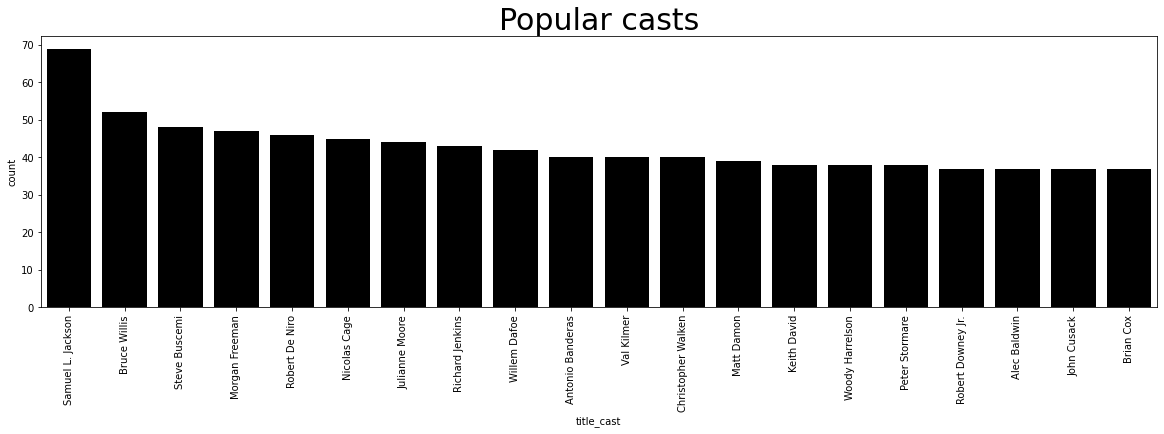

In [49]:
# Plot popular casts
plt.figure(figsize = (20,5))
casts=imdb_casts['title_cast'].explode()
ax=sns.countplot(x=casts, order = casts.value_counts().index[:20],color='black')
ax.set_title('Popular casts',fontsize=30)
plt.xticks(rotation=90)
plt.show()

Looking at the top 3 popular cast we are able to see that they are very well known actors.People usually prefer watching movies based on the actors that they know.Movies with well known actors usually have a higher rating compared to actors that viewers are not yet familiar with.

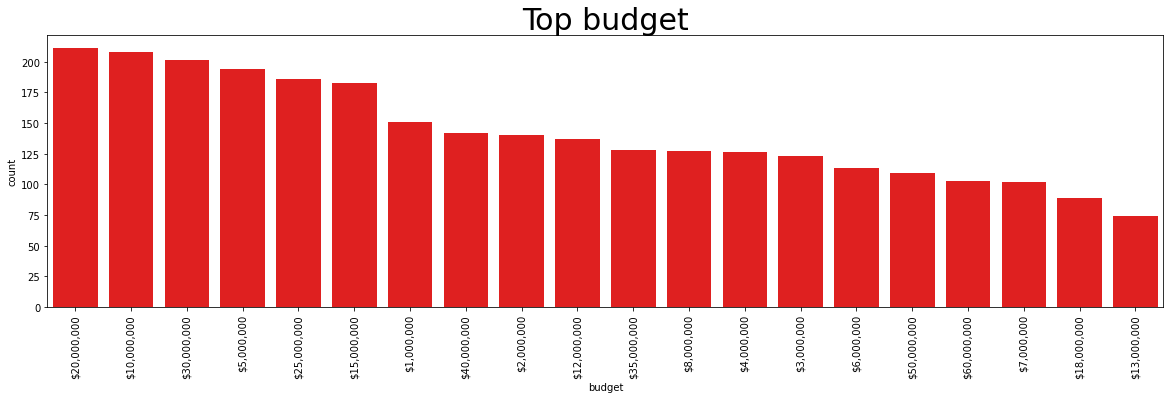

In [50]:
#budget
plt.figure(figsize = (20,5))
budget=imdb_data['budget'].explode()
ax=sns.countplot(x=budget, order = budget.value_counts().index[:20],color='red')
ax.set_title('Top budget',fontsize=30)
plt.xticks(rotation=90)
plt.show()



A film’s budget plays a prominent role throughout the film’s life cycle—with ramifications reaching far beyond the basic cost of the picture,with a huge budget, it's simpler to go all out with the film, such as using a lot of visual effects.In comparison to a low-budget picture, a great amount of marketing may be done for a high-budget film, which is why, despite having poorer stories, they are more likely to appear in a movie theater and collect a larger sum of money. 


<AxesSubplot:>

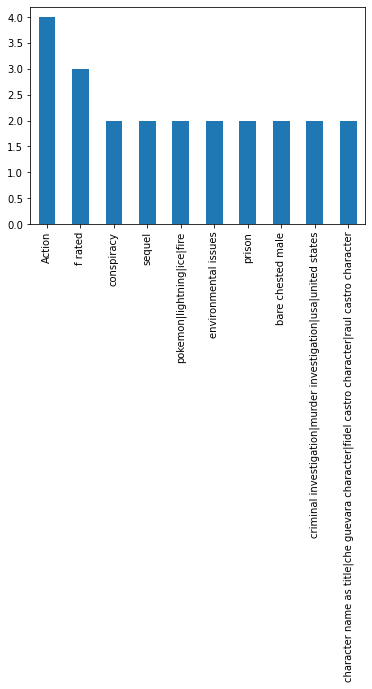

In [52]:
imdb_data['plot_keywords'].value_counts()[:10].plot(kind='bar')

The Internet Movie Database, or IMDB, is a website that contains virtually every detail on every single film that has ever been released. The only issue is that the IMDB search engine is really basic. You can seek up an actor, director, or production firm, but you'll have to scroll through their page and sift through their filmography to find the one you want.Here we are able to see the top plotkeywords that people normally search for to look at the movies they want.We are able to see action being one of the most frequent words and action movies are among one of the top 5 most common genres

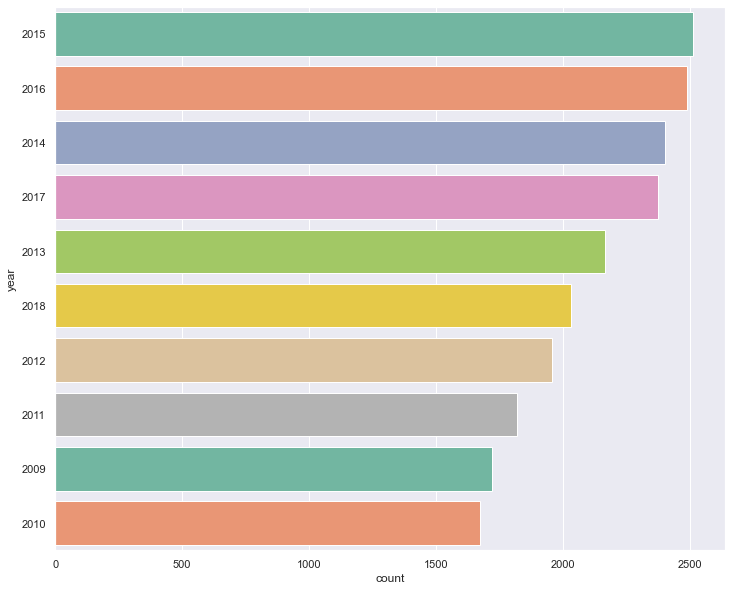

In [58]:
movies['y'] = movies['title'].str.split(' ')
movies['year'] = movies['y'].apply(lambda x: x[-1])
movies['year'] = movies['year'].str.strip(')')
movies['year'] = movies['year'].str.strip('(')
# lets drop the unnecessary 'y' column from the dataset
movies = movies.drop(['y'], axis = 1)
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y="year", data=movies, palette="Set2", order=movies['year'].value_counts().index[0:10])

We are able to visualise that 2015 has the most movies in our dataset, closely followed by the year 2016.

C:\Users\2380323\Anaconda3\New folder\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='runtime', ylabel='Density'>

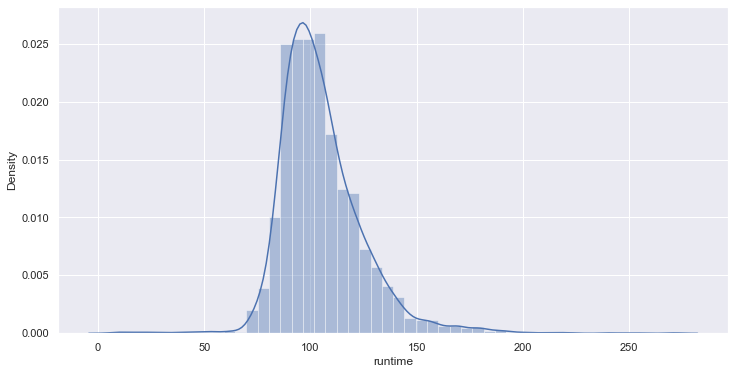

In [59]:
data = pd.merge(movies, imdb_data, on = 'movieId', how = 'inner')

##As we do not Require the MovieId, title_cast, director and plot_keywords lets remove them
data = data.drop(['movieId', 'title_cast', 'director','plot_keywords'], axis = 1)

       
plt.figure(figsize=(12,6))
sns.distplot(data[(data['runtime'] < 300) & (data['runtime'] > 0)]['runtime'])                               

So, a good amount of movies are among the duration of 90-120 mins.It is approximately the maximum time in which a large majority of the viewers can sit without going to the toilet and without drinking. It is acceptable considering the fact that a fair amount of the audience cannot watch a 3 hour movie in one sitting.

The total number of movies with  Drama = 3267
The total number of movies with  Comedy = 2260
The total number of movies with  Documentary = 202
The total number of movies with  Comedy|Drama = 4809
The total number of movies with  Drama|Romance = 3648


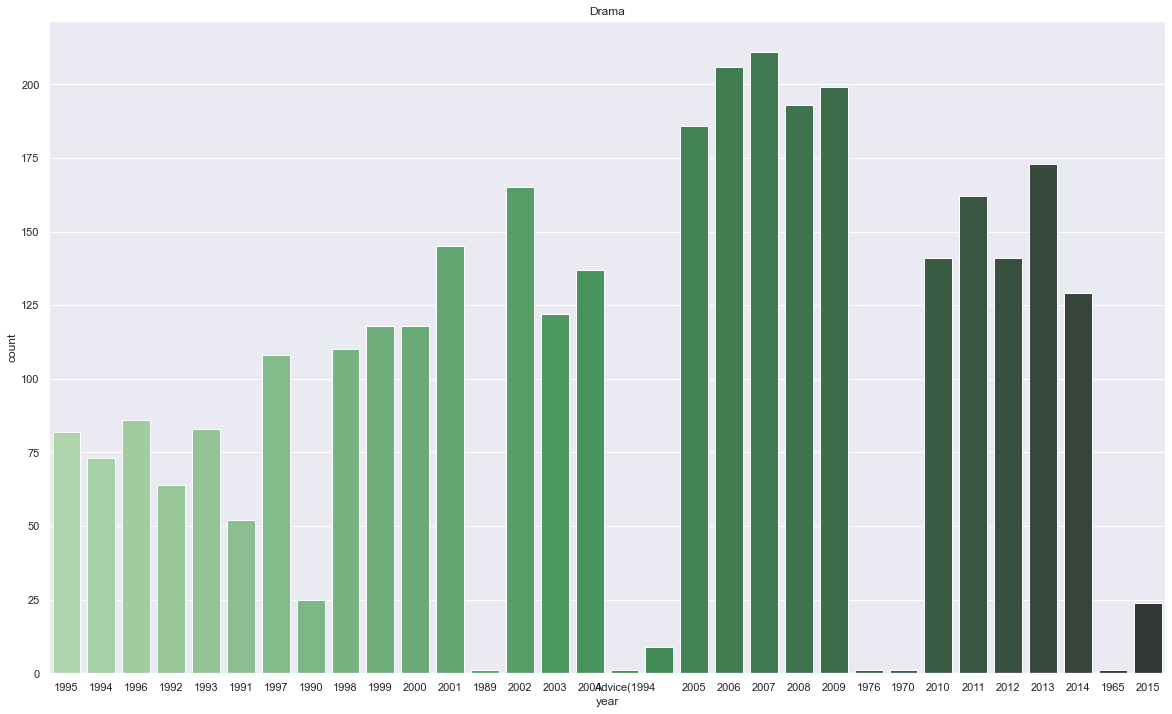

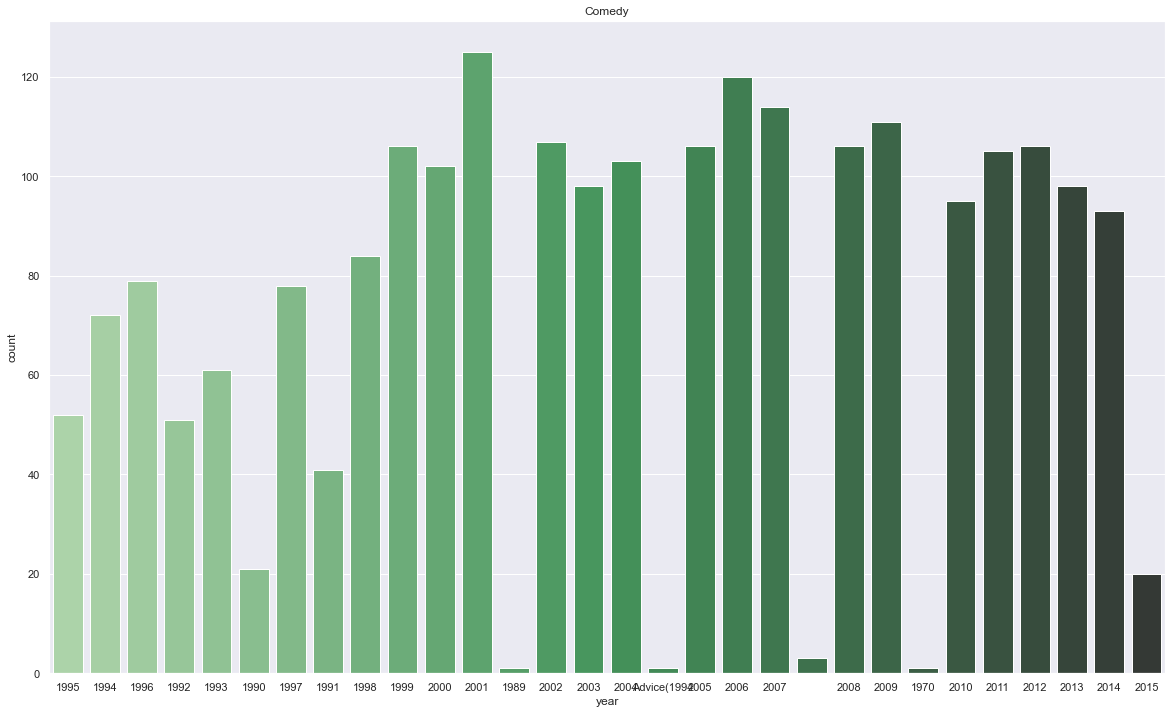

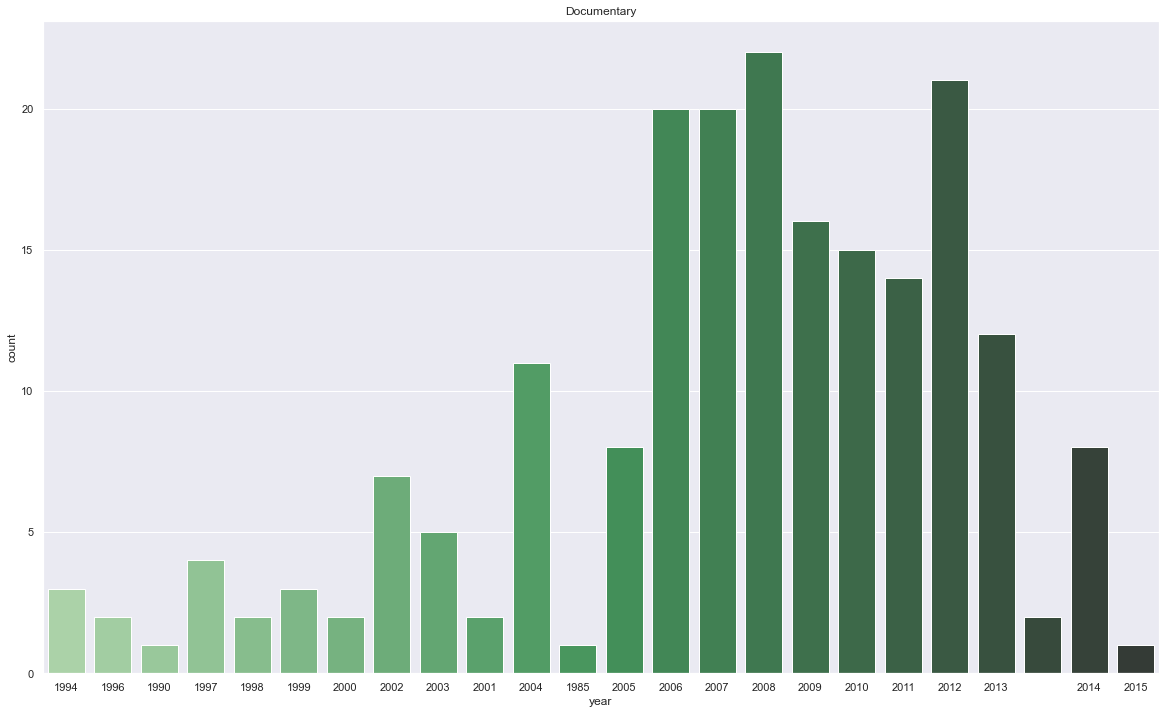

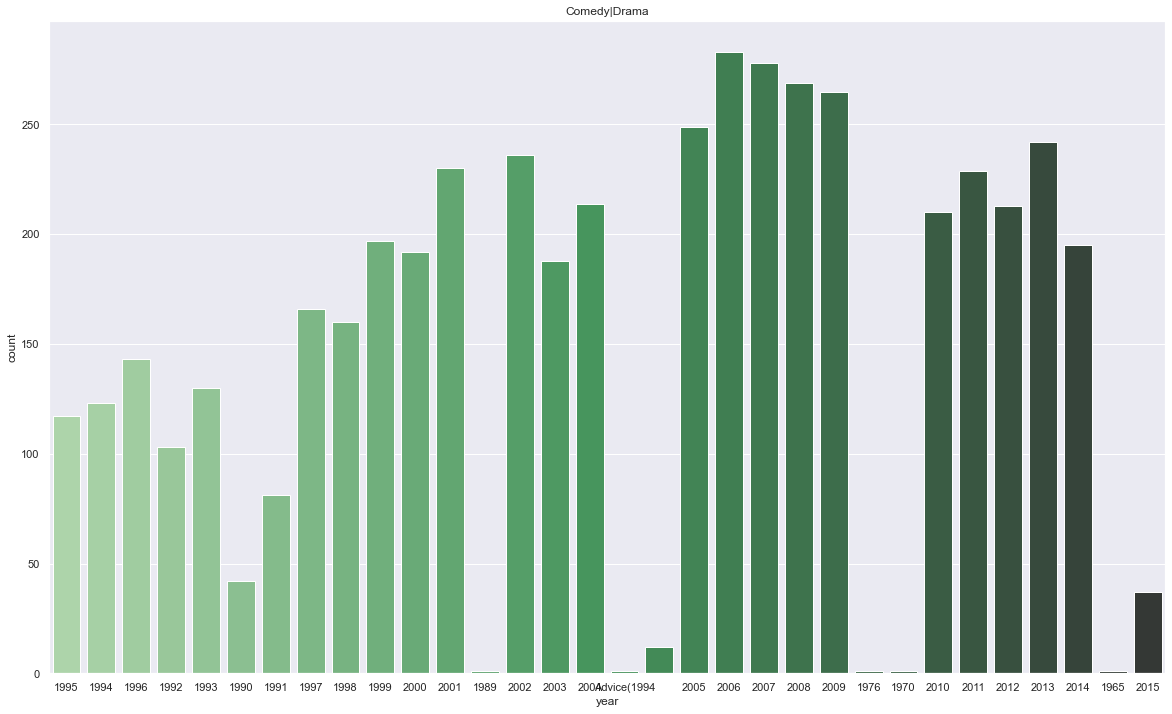

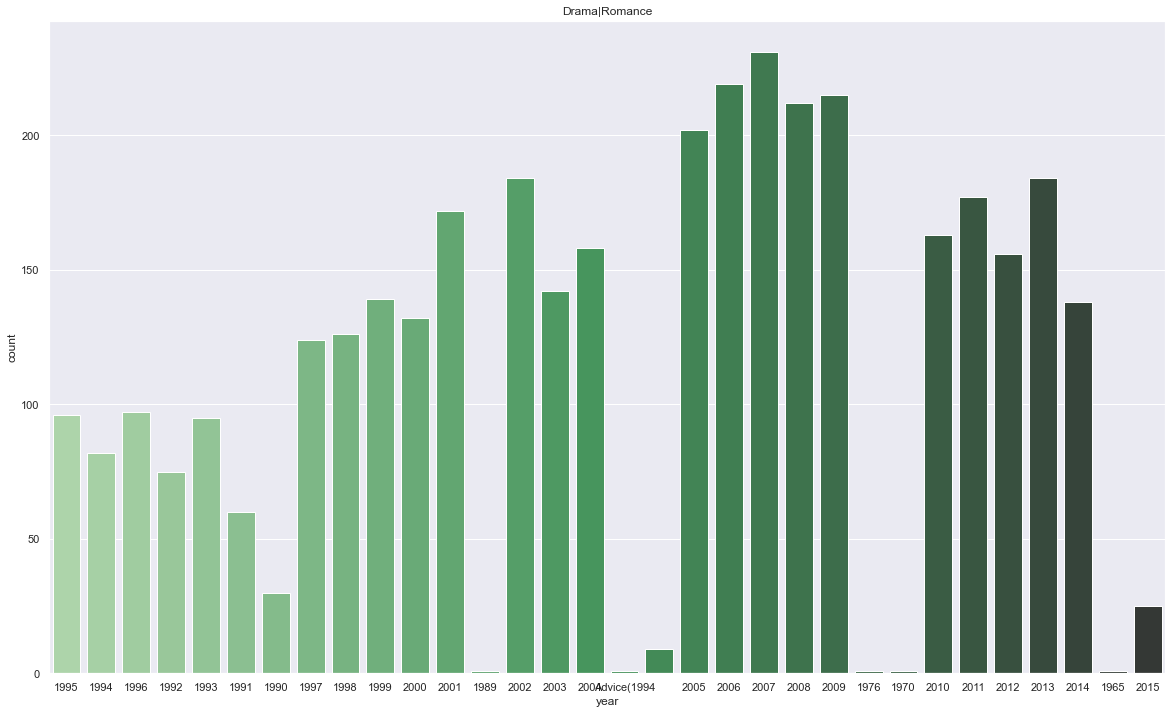

In [55]:
seperate_genre='Drama','Comedy','Documentary','Comedy|Drama','Drama|Romance'
for genre in seperate_genre:
    df = data['genres'].str.contains(genre).fillna(False)
    print('The total number of movies with ',genre,'=',len(data[df]))
    f, ax = plt.subplots(figsize=(20, 12))
    sns.countplot(x='year', data=data[df], palette="Greens_d");
    plt.title(genre)

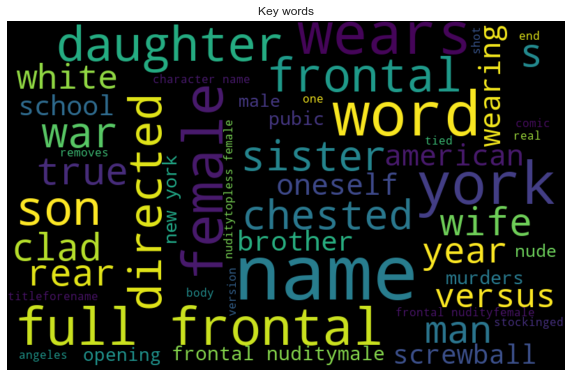

In [56]:
#word cloud for key words that people use while searching
all_words = ''.join([label for label in imdb_keywords['plot_keywords']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Key words')

plt.show()

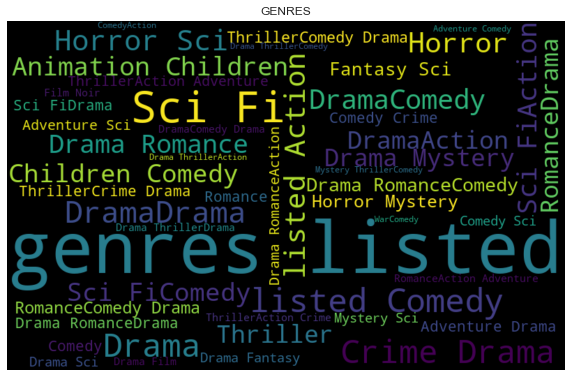

In [57]:
#word cloud for genre

all_words = ''.join([label for label in movies['genres']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('GENRES')

plt.show()

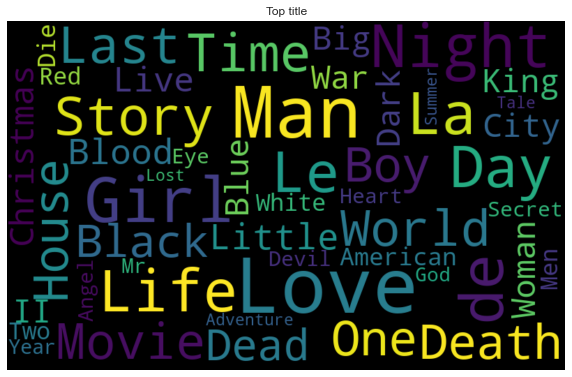

In [58]:
#word cloud for top title
from wordcloud import WordCloud
all_words = ''.join([label for label in movies['title']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top title')

plt.show()

The words love, Girl, Day and Man are the most commonly used word in movie titles.